생일생성
ex) 000429

In [ ]:
import torch
import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt

import random

In [ ]:
# 진짜 데이터 생성, 000429
def generate_real():
  real_data = torch.FloatTensor(
      [random.uniform(-0.1, 0.1)/10,
       random.uniform(-0.1, 0.1)/10,
       random.uniform(-0.1, 0.1)/10,
       random.uniform(3.9, 4.1)/10,
       random.uniform(1.9, 2.1)/10,
       random.uniform(8.9, 9.1)/10]
       )
  return real_data

In [ ]:
# 판별자 클래스
class Discriminator(nn.Module):

  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    # 입력 6 -> 출력 3 -> 시그모이드 -> 입력 3 -> 출력 1 -> 시그모이드
    self.model = nn.Sequential(
        nn.Linear(6, 3),
        nn.Sigmoid(),
        nn.Linear(3, 1),
        nn.Sigmoid()
    )

    # 손실함수 설정
    self.loss_function = nn.MSELoss()

    # SGD 옵티마이저 설정
    # self.parameters() 모든 학습 파라미터
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass
  
  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)
  

  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    # 손실 계산
    loss = self.loss_function(outputs, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass
    
    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimizer.zero_grad()   # 계산 그래프의 기울기 0으로 초기화
    loss.backward()   # 신경망의 기울기
    self.optimizer.step()   # 위 기울기는 이 코드를 통해서 신경망의 학습 파라미터를 갱신하는데에 사용됨

    pass
  
  def plot_progress(self):
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass


In [ ]:
# 가짜 데이터 생성
def generate_random(size):
  random_data = torch.rand(size)
  return random_data

In [ ]:
# 판별기 테스트해보기
D = Discriminator()

for i in range(10000):
  # 실제 데이터에 대해 1으로 학습
  D.train(generate_real(), torch.FloatTensor([1.0]))
  # 생성된 데이터에 대해 0으로 학습
  D.train(generate_random(6), torch.FloatTensor([0.0]))
  pass

counter =  10000
counter =  20000


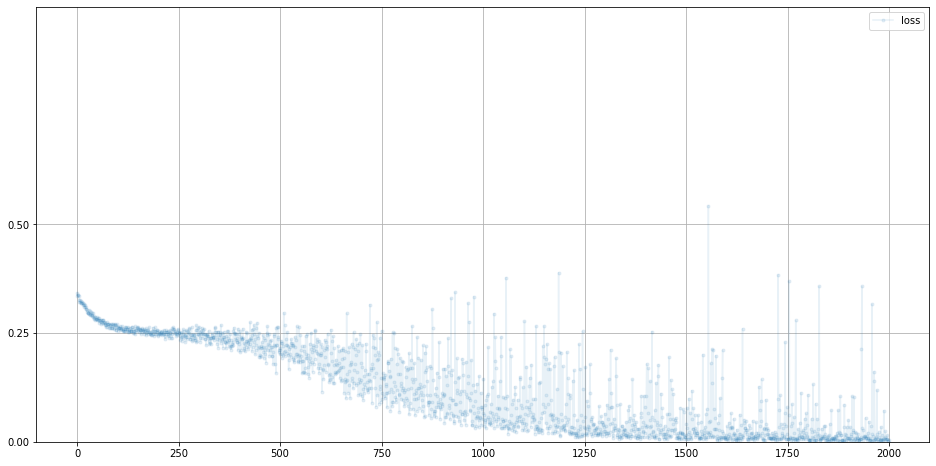

In [ ]:
D.plot_progress()

In [ ]:
# 생성자 클래스
class Generator(nn.Module):

  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    # 입력 1 -> 출력 3 -> 시그모이드 -> 입력 3 -> 출력 4 -> 시그모이드
    self.model = nn.Sequential(
        nn.Linear(1, 3),
        nn.Sigmoid(),
        nn.Linear(3, 6),
        nn.Sigmoid()
    )

    # SGD 옵티마이저 설정
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass
  
  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)
  

  def train(self, D, inputs, targets):
    # 신경망 출력 계산
    # 생성자 모델의 예측값
    g_output = self.forward(inputs)

    # 판별기로 전달
    # 생성자 모델의 예측값을 판별자 모델의 인풋으로 넣어 판별자 모델의 예측값 도출
    d_output = D.forward(g_output)

    # 오차 계산
    # 판별자 모델의 예측값과 라벨에 대한 손실값 도출
    loss = D.loss_function(d_output, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass
    
    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    pass
  
  def plot_progress(self):
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass


In [ ]:
%time

# 판별기 및 생성기 생성

D = Discriminator()
G = Generator()

# 판별기와 생성기 훈련

for i in range(45000):

  # 1단계: 참에 대해 판별기 훈련
  D.train(generate_real(), torch.FloatTensor([1.0]))

  # 2단계: 거짓에 대해 판별기 훈련
  # G의 기울기가 계산되지 않도록 detach() 함수를 이용
  D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))

  # 3단계: 생성기 훈련
  G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))

  pass

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
counter =  10000
counter =  20000
counter =  10000
counter =  30000
counter =  40000
counter =  20000
counter =  50000
counter =  60000
counter =  30000
counter =  70000
counter =  80000
counter =  40000
counter =  90000


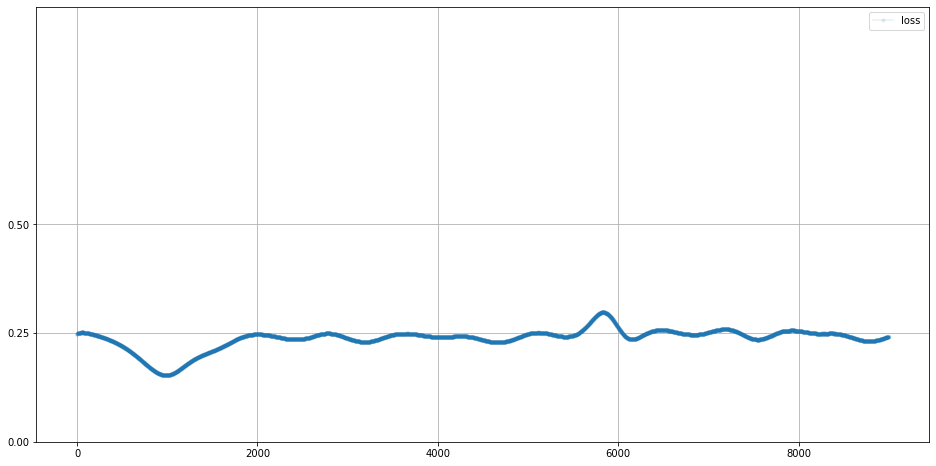

In [ ]:
D.plot_progress()

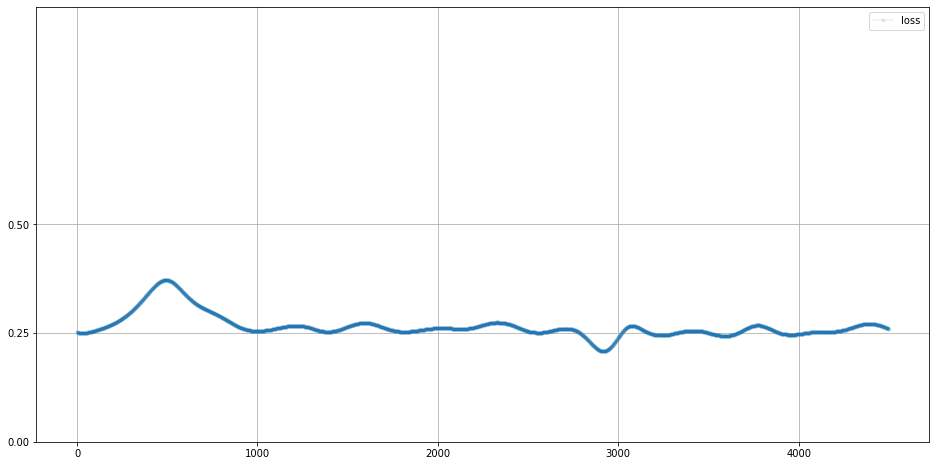

In [ ]:
G.plot_progress()

In [ ]:
G.forward(torch.FloatTensor([0.5])) * 10

tensor([0.0174, 0.0142, 0.0156, 3.8656, 1.6939, 9.7058],
       grad_fn=<MulBackward0>)